## Using Tracker

In this notebook, I'll demonstrate using `Tracker` and related features of `orcabridge` to keep *track* of all `operations` you are using in a pipeline and to automatically construct computation graph based on it.

In [1]:
from orcabridge.pod import function_pod
from orcabridge.source import GlobSource
from orcabridge.store import DirDataStore
from orcabridge.tracker import Tracker

As before let's construct a simple data pipeline that reads files and counts the number of lines, saving that information into another file. We will then chain it with another function that converts JSON to YAML.

In [2]:
data_source = GlobSource("data_file", "../examples/dataset1", "*.txt")

We are also going to define a few functions to serve as function pods. We are using convenience function `function_pod` to decorate the function to immediately turn them into a `FunctionPod` as was covered [in previous notebook](./03_orcabridge_qol_features.ipynb).

In [3]:
import json
import tempfile
from pathlib import Path

import yaml

# use default data store location of `./pod_data`
data_store = DirDataStore()


# function to count lines in a file and save it as JSON
@function_pod(["stats"], data_store=data_store)
def count_lines(file: str):
    with open(file, "r") as f:
        n = len(f.readlines())
    tmp_dir = tempfile.mkdtemp()
    data_file = Path(tmp_dir) / "data.json"
    data = dict(lines=n)
    with open(data_file, "w") as f:
        json.dump(data, f)
    return data_file


@function_pod(["yaml_file"], data_store=data_store)
def json_to_yaml(json_file: str):
    with open(json_file, "r") as f:
        data = json.load(f)
    tmp_dir = tempfile.mkdtemp()
    yaml_path = Path(tmp_dir) / Path(json_file).with_suffix(".yaml").name
    with open(yaml_path, "w") as f:
        yaml.dump(data, f)
    return yaml_path


# function to extract keys from a JSON file and save them as a list in another JSON file
@function_pod(["key_info"], data_store=data_store)
def extract_keys(json_file: str):
    with open(json_file, "r") as f:
        data = json.load(f)
    keys = list(data.keys())
    tmp_dir = tempfile.mkdtemp()
    keys_file = Path(tmp_dir) / "keys.json"
    with open(keys_file, "w") as f:
        json.dump(keys, f)
    return keys_file

With all steps defined, let's chain them together to form a full pipeline. Note that we are using the `>>` operator to map packet keys on the fly to match expected arguments for each pod.

In [4]:
line_info_json = count_lines(data_source >> {"data_file": "file"})
line_info_yaml = json_to_yaml(line_info_json >> {"stats": "json_file"})
line_info_keys = extract_keys(line_info_json >> {"stats": "json_file"})

In [5]:
line_info_keys.head()

Tag: {'file_name': 'day1'}, Packet: {'key_info': 'pod_data/extract_keys/cf978f9c23318c91/c4c3939c-aced-18ac-8a7c-330f07780bbd/keys.json'}
Tag: {'file_name': 'day2'}, Packet: {'key_info': 'pod_data/extract_keys/cf978f9c23318c91/61e78af0-346a-00f7-df3d-f2ec1693a84e/keys.json'}
Tag: {'file_name': 'day3'}, Packet: {'key_info': 'pod_data/extract_keys/cf978f9c23318c91/92fbcba4-a642-4105-8be2-c01ce9c3e12e/keys.json'}
Tag: {'file_name': 'day4'}, Packet: {'key_info': 'pod_data/extract_keys/cf978f9c23318c91/9e7da977-1ed3-03a2-ffd5-a3d626c286d8/keys.json'}


In [6]:
line_info_yaml.head()

Tag: {'file_name': 'day1'}, Packet: {'yaml_file': 'pod_data/json_to_yaml/0a2282eda2b641e6/c4c3939c-aced-18ac-8a7c-330f07780bbd/data.yaml'}
Tag: {'file_name': 'day2'}, Packet: {'yaml_file': 'pod_data/json_to_yaml/0a2282eda2b641e6/61e78af0-346a-00f7-df3d-f2ec1693a84e/data.yaml'}
Tag: {'file_name': 'day3'}, Packet: {'yaml_file': 'pod_data/json_to_yaml/0a2282eda2b641e6/92fbcba4-a642-4105-8be2-c01ce9c3e12e/data.yaml'}
Tag: {'file_name': 'day4'}, Packet: {'yaml_file': 'pod_data/json_to_yaml/0a2282eda2b641e6/9e7da977-1ed3-03a2-ffd5-a3d626c286d8/data.yaml'}


We have now defined a nontrivial data pipeline that counts the number of lines in files and output that info to JSON. We then convert the JSON files into YAML files. On the other branch of the pipeline, we take the JSON files and extract a list of keys found in the JSON and save it as yet another JSON file.

As your pipeline grows, it can get qutie tricky to keep track of exactly who connects to what and it can be easy to lose sight of exactly what's going on in the pipeline. This is exactly where `Tracker` comes in handy. As the name suggeests, a `Tracker` can keep track of all pipeline-defining computations you have run, and then generate helpful information such as graphs or plot the graph as an image for visualization.

You may think that the sensible next step is to create and setup a `Tracker` to keep track of the pipeline. It turns out that `orcabridge` comes with a default tracker that has been tracking all of the pipeline-defining operation all this time, secretly without you knowing!

Let's access and use the default tracker.

In [7]:
from orcabridge import DEFAULT_TRACKER

As we will see shortly, `DEFAULT_TRACKER` is just an ordinary instance of `Tracker` that has been instantiated and activated at the time of the first import of `orcabridge`. Consequently, it has been keeping track of all `operation` execution that you have performed thus far. Let's use its `draw_graph()` to display the computation graph it has detected.

/home/eywalker/workspace/orcabridge/src/orcabridge/tracker.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


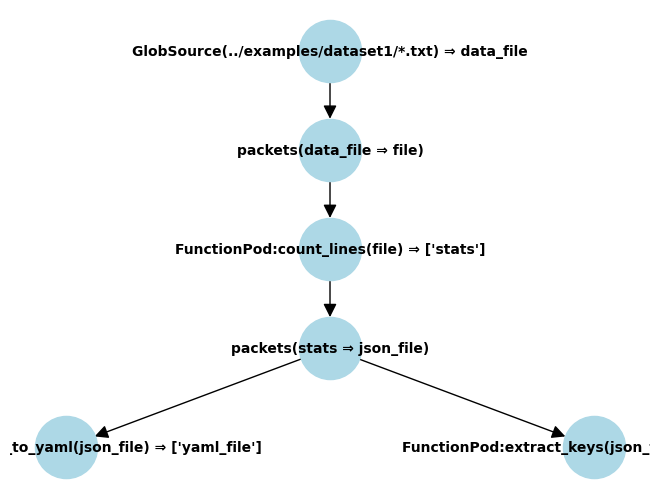

In [8]:
DEFAULT_TRACKER.draw_graph()

Does that match what you thought of the pipeline thus far? You might notice that while we used the convenience operator `>>` to map packet keys, the corresponding `MapPackets` mapper actually shows up in the graph. Remember that `>>` is just for convenience, making the creation of `MapPackets` and `MapTags` more accesible.

## Explicitly tracking computation pipeline with a tracker

While the `DEFAULT_TRACKER` can serve as a nice catch-all tracker, sometimes you'd want to explicitly control what gets tracked so that you can visualize specific section of the entire computation graph. 

To do so, you would want to create your own tracker, and define the computation using the tracker's context manager. Let's see an example.

In [9]:
# instantiate a new tracker
tracker = Tracker()

# start a context manager to track the pipeline
with tracker:
    line_info_json = count_lines(data_source >> {"data_file": "file"})
    line_info_keys = extract_keys(line_info_json >> {"stats": "json_file"})

# perform the conversion outside of the tracker
line_info_yaml = json_to_yaml(line_info_json >> {"stats": "json_file"})

In the example above, you would notice that only first half of the pipeline is chained together within the `tracker` context manager. Let's now see what the graph looks like.

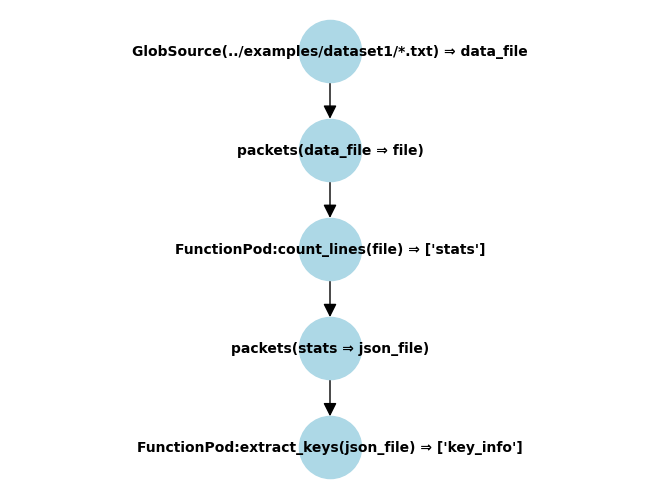

In [10]:
tracker.draw_graph()

As you can see, the tracker only tracked one branch of the computation graph, leaving the other branch outside of the computation graph it has constructed and visualized.

## Labeling operations

All operations accept `label` keyword argument when creating and also has property `.label` where you can change it at any time you like. If `label` attribute of an operation is not `None`, the value will be used instead to label the operation node in the graph. In fact, you can change the label after the pipeline construction, and the change will still be reflected the next time you draw the graph!

In [11]:
data_source.label = "LocalDataStore"

count_lines.label = "CountLines"

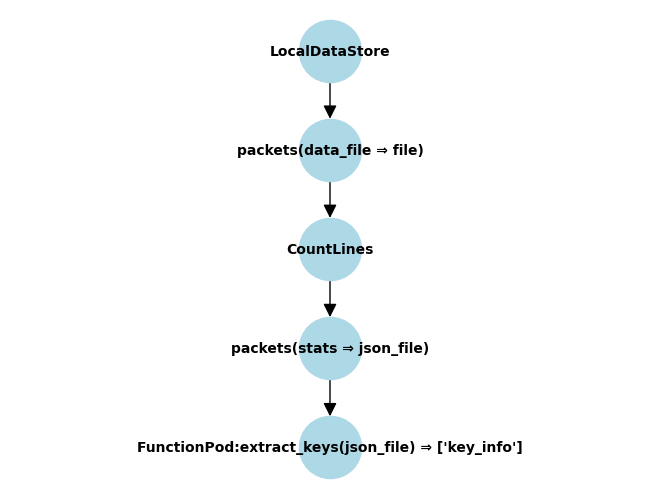

In [12]:
tracker.draw_graph()

You can always get the orginal label back by setting label to `None`:

In [13]:
count_lines.label = None

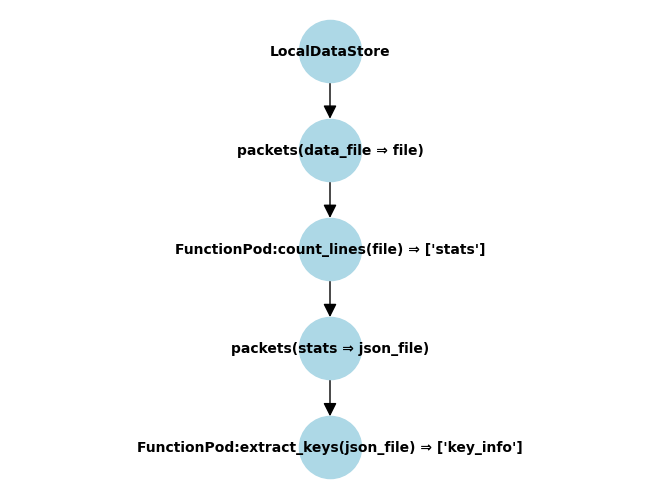

In [14]:
tracker.draw_graph()